# Сверточная сеть
В этом ноутбуке мы расширим предыдущий и создадим первую сверточную сеть

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import os
import pandas as pd
from torchvision.io import read_image


# Создание датасета

Загрузим FashionMNIST (https://github.com/zalandoresearch/fashion-mnist)


In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [5]:
def plot_samples(data, labels_map, cols=3, rows=3):
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        if type(label) == torch.Tensor:
            plt.title(labels_map[label.item()])
        else:
            plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

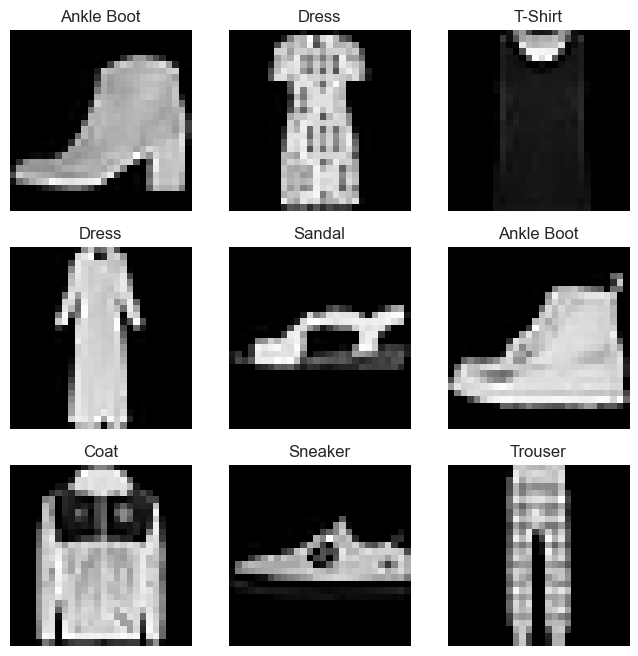

In [6]:
plot_samples(train_data, labels_map, cols=3, rows=3)

In [7]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


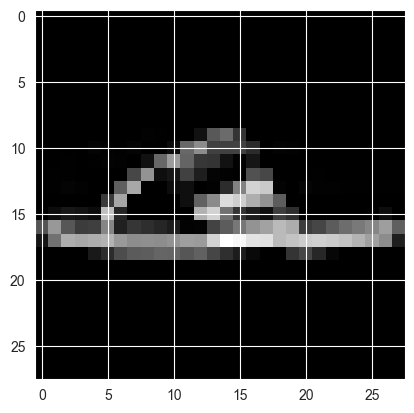

Label: 5


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().reshape(28,28)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


Теперь создадим класс модели и интстанциируем её. В данном случае это простой перцептрон с тремя слоями. Однако модель может быть сколько угодно сложной. Главное, чтобы она наследовала класс `nn.Module`. Более того, можно написать любой слой собственноручно, также отнаследовав этот класс.
Каждая модель должна имплементировать два метода - `__init__` и `forward(self, *args, **kwargs)`. В первом обычно задается ее структура и другие параметры. Модель  может даже содержать другие модели!

`forward` получает на вход Х, но он может получать несколько разных входов, маски и тд. Обычно возвращаются либо выходы с последнего слоя (один или несколько). Но, например, стандартные модели детекции возвращают в режиме обучения значение лосса, а непосредственные предсказания только в режиме тестирования.

Вызывая `model(data)`, на самом деле мы вызываем именно метод `forward`

Можете создавать модель со мной, можете придумать свою.

In [69]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.pool = nn.AvgPool2d(kernel_size=28)
        self.head = nn.Linear(16, 10)

    def forward(self, x):
        x = self.base(x)
        # Необходимо превратить вход в вектор, чтобы можно было применить линейный слой
        x = self.pool(x)
        x = x.squeeze(2)
        x = x.squeeze(2)
        logits = self.head(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (base): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool): AvgPool2d(kernel_size=28, stride=28, padding=0)
  (head): Linear(in_features=16, out_features=10, bias=True)
)


Часто вместо решейпа перед головой используют пулинг. Это специальный слой, который накладывается на вход и позволяет получить его преобразование (max, avg) без весов:
![alt text](..\additional_materials\images\max_pool.png "Stride=1, padding=0")

Если сделать MaxPool2d или AvgPool2d с размером ядра, равным размеру входа, то получится вектор такого же размера, как исходное число каналов. Однако, все равно придется добавить дополнительное измерение.

**Задание**: Измените модель, используя MaxPool или AvgPool вместо view(). Сравните результаты.

### После этих изменений модель стала обучаться дольше и после 10 итераций точность стала вместо 90%:
### 50% для avg pool и 75% для maxpool

Зададим функцию ошибки и оптимизатор. Функция ошибки также наследуется от torch.nn.Module и может быть стандартной, состоять как из нескольких стандартных функций или их модификаций. Большое количество функций ошибки уже реализовано в Pytorch.

Внутри каждой итерации обучения оптимизация происходит в три этапа:
Вызов optimizer.zero_grad() для обнуления градиентов параметров модели. Градиенты по умолчанию складываются; чтобы избежать двойного подсчета, мы явно обнуляем их на каждой итерации.

Получение градиентов для каждого веса с помощью loss.backward().
Как только мы получили наши градиенты, остается вызвать optimizer.step(), чтобы изменить параметры в соответствии с нашим алгоритмом оптимизации. 

In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Обучим модель. Для этого нужно описать цикл обучения и проверки модели. В наивном случае создается две функции train и validate (test), которые вызываются в цикле по эпохам. В дальнейшем, при усложнении прохода по эпохе, может появиться метод train, целый класс Trainer и т.д. Пока что реализуем наивный вариант.

In [71]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    min_loss = float("inf")
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute prediction error
        preds = model(inputs.float())
        loss = loss_fn(preds, targets)
        if loss < min_loss:
            min_loss = loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            loss, current = loss.item(), (batch_idx + 1) * len(preds)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        ''' Чтобы сделать задание со сравнением лоссов, не забудьте 
            реализовать трекинг минимального лосса  '''
    print(f'Min loss: {min_loss:>5f}')
    return min_loss

In [72]:
from sklearn.metrics import precision_score, recall_score

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0, 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs.float())
            num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
            test_loss += loss_fn(preds, targets).item()
            
            # Store predictions and targets for metrics computation
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss /= num_batches
    num_correct /= size
    
    # Compute precision and recall
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=np.nan)

    print(f"Test Error: \n Accuracy: {(100*num_correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    print(f"Precision: {100*precision:>0.1f}%, Recall: {100*recall:>0.1f}% \n")
    return test_loss


Задание: Добавьте метрики precision и recall для проверки

In [73]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    # ваш код

Epoch 1
-------------------------------
loss: 2.347935  [   64/60000]
loss: 2.330087  [ 6464/60000]
loss: 2.233402  [12864/60000]
loss: 2.361646  [19264/60000]
loss: 2.280068  [25664/60000]
loss: 2.265072  [32064/60000]
loss: 2.228052  [38464/60000]
loss: 2.249541  [44864/60000]
loss: 2.233261  [51264/60000]
loss: 2.308193  [57664/60000]
Min loss: 2.139765
Test Error: 
 Accuracy: 20.2%, Avg loss: 2.237985
Precision: 15.4%, Recall: 20.2% 

Epoch 2
-------------------------------
loss: 2.237007  [   64/60000]
loss: 2.252898  [ 6464/60000]
loss: 2.249353  [12864/60000]
loss: 2.249748  [19264/60000]
loss: 2.259775  [25664/60000]
loss: 2.228672  [32064/60000]
loss: 2.215542  [38464/60000]
loss: 2.205510  [44864/60000]
loss: 2.199928  [51264/60000]
loss: 2.220358  [57664/60000]
Min loss: 2.134822
Test Error: 
 Accuracy: 25.1%, Avg loss: 2.188367
Precision: 23.1%, Recall: 25.1% 

Epoch 3
-------------------------------
loss: 2.192546  [   64/60000]
loss: 2.179507  [ 6464/60000]
loss: 2.165519

Осталось сохранить модель для дальнейшего использования.

Задание: придумайте свою собственную модель, на следующем занятии сравнимся, у кого получилось достичь наилучших результатов.

In [21]:
class my_model(nn.Module):
    def __init__(self):
        super(my_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        return x

In [22]:
model = my_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [23]:
train_losses = []
test_losses = []
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer).detach().cpu().numpy()
    test_loss = test(test_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch 1
-------------------------------
loss: 2.291904  [   64/60000]
loss: 0.415659  [ 6464/60000]
loss: 0.534822  [12864/60000]
loss: 0.446342  [19264/60000]
loss: 0.381868  [25664/60000]
loss: 0.390123  [32064/60000]
loss: 0.322714  [38464/60000]
loss: 0.476868  [44864/60000]
loss: 0.257663  [51264/60000]
loss: 0.285582  [57664/60000]
Min loss: 0.103174
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.349717
Precision: 87.6%, Recall: 87.3% 

Epoch 2
-------------------------------
loss: 0.209913  [   64/60000]
loss: 0.223769  [ 6464/60000]
loss: 0.380609  [12864/60000]
loss: 0.447368  [19264/60000]
loss: 0.257652  [25664/60000]
loss: 0.245585  [32064/60000]
loss: 0.252539  [38464/60000]
loss: 0.225516  [44864/60000]
loss: 0.511803  [51264/60000]
loss: 0.268969  [57664/60000]
Min loss: 0.085566
Test Error: 
 Accuracy: 89.1%, Avg loss: 0.302056
Precision: 89.3%, Recall: 89.1% 

Epoch 3
-------------------------------
loss: 0.236763  [   64/60000]
loss: 0.182548  [ 6464/60000]
loss: 0.248512